Importation de Modules utiles et définitions de certains termes.

In [2]:
from scipy.constants import Avogadro, c, m_e, m_p, e, physical_constants
from pandas.plotting import table
from functools import partial, lru_cache
from timeit import timeit
import scipy.stats
import csv
import scipy.integrate as integrate
from scipy.integrate import quad
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

eV_to_MeV = 1e-6            #Convertion eV vers MeV.

m_p = m_p  * eV_to_MeV/e    # Masse du proton en MeV/c^2
m_e = m_e  * eV_to_MeV/e    # Masse de l'électron en MeV/c^2

r_e = physical_constants["classical electron radius"][0] * 1e2      # cm

# Q1
Exprimez la densité électronique $n_e$ d’un milieu en fonction de sa composition atomique et de sa masse volumique $\rho$, et calculer $n_e$ pour l’eau (liquide) et l’os compact (définition de l’ICRU). On s’appuiera sur les données du NIST pour les compositions atomiques de ces matériaux.

-------------VÉRIFIÉ_AVEC_AUTRE_ÉQUIPE_C'EST_GOOD--------------

In [3]:
n_e = lambda atomic_numbers, fractions_by_weight, rho, A: rho * Avogadro * np.sum(atomic_numbers * fractions_by_weight/A)

I_bone = 91.9 * eV_to_MeV                                                                                               # Mean Excitation Energy en MeV de l'eau liquide.
rho_bone = 1.85                                                                                                         # Densité de l'os Compact en g/cm^3
atomic_numbers_bone = np.array([1, 6, 7, 8, 12, 15, 16, 20])                                                            # Nombre atomique.
fractions_by_weight_bone = np.array([0.063984, 0.278000, 0.027000, 0.410016, 0.002000, 0.070000, 0.002000, 0.147000])   # Fractions Massiques.
AtomicMasses_bone = np.array([1.007975, 12.0106, 14.006855, 15.99940, 24.3055, 30.973762, 32.0675, 40.078])             # Masses Atomiques.

n_e_bone = n_e(atomic_numbers_bone, fractions_by_weight_bone, rho_bone, AtomicMasses_bone)                              # Densité électronique de l'Os Compact

I_water = 75 * eV_to_MeV                                                                                                # Mean Excitation Energy en MeV de l'eau liquide.
rho_water = 1                                                                                                           # Densité de l'eau liquide en g/cm^3
atomic_numbers_water = np.array([1, 8])                                                                                 # Nombre atomique.
fractions_by_weight_water = np.array([0.111894, 0.888106])                                                              # Fractions Massiques.
AtomicMasses_water = np.array([1.008, 15.999])                                                                          # Masses Atomiques.

n_e_water = n_e(atomic_numbers_water, fractions_by_weight_water, rho_water, AtomicMasses_water)                         # Densité électronique de l'eau liquide

print(f"Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de {n_e_bone} e-/cm\u00b3 et {n_e_water} e-/cm\u00b3.")

Les densités électroniques de l'os compact et de l'eau liquide sont respectivement de 5.905891191511755e+23 e-/cm³ et 3.342810286137214e+23 e-/cm³.


# Q2

Tracez les courbes du pouvoir d’arrêt collisionnel massique pour ces milieux en fonction de l’énergie cinétique (T). Pour expliciter la dépendance en T de Scol, utilisez les relations 9 et 10 ci-bas. Pour le graphique, utilisez une échelle logarithmique en abscisse. Vous trouverez les énergies moyennes d’excitation I de ces matériaux sur le site du NIST également. L’approximation d’une décélération continue (Continuous Slowing Down Approximation, CSDA) des protons dans la matière, en ligne droite, permet d’estimer leur portée dans le milieu considéré (la distance qu’ils peuvent parcourir avant d’avoir transféré au milieu la totalité de leur énergie cinétique initiale). Ici, seuls les transferts d’énergie vers les électrons du milieu sont considérés.

Équation 9 :
$$
T = (\gamma - 1) m_p c^2 \Rightarrow \gamma = \frac{T}{m_p c^2} + 1
$$
Équation 10 :
$$
\gamma = \frac{1}{\sqrt{1 - \beta^2}} \Rightarrow \gamma^2 \beta^2 = (\gamma^2 - 1)
$$


Certaines Équations sont utiles afin de faire ce problème :

Équation 3:
$$
T_e^{max} = \frac{2 m_e c^2 (\gamma^2 - 1)}{1 + 2 \gamma \frac{m_e}{m_p} + \left( \frac{m_e}{m_p} \right)^2}
$$
Équation 4:
$$
S_{col} = 2\pi r_e^2 m_e c^2 n_e \frac{1}{\beta^2} \big[\ln\big(\frac{2 m_e c^2 \beta^2 \gamma^2 T_e^{max}}{I^2}\big) - 2 \beta^2\big]
$$
-------------VÉRIFIÉ_AVEC_AUTRE_ÉQUIPE_C'EST_GOOD-------------

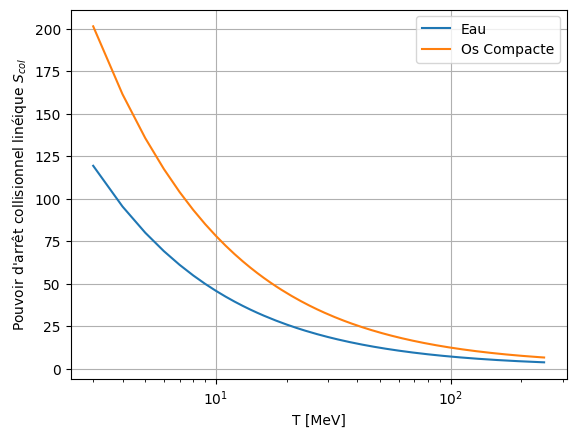

In [4]:
def gamma(T):   # Implémentation de l'équation 9.
    gamma = T/(m_p*c**2) + 1
    return gamma

def beta(T):    # implémentation de l'équation 10.
    beta = np.sqrt((gamma(T)**2 - 1)/gamma(T)**2)
    return beta

def t_max(T):   # implémentation de l'équation 3.
    t_max = (2*m_e*c**2 * (gamma(T)**2 - 1))/(1 + 2*(m_e/m_p)*gamma(T) + (m_e/m_p)**2)
    return t_max

def s_col(T, n_e, I_MeV):   # implémentation de l'équation 4.
    constant = 2 * np.pi * r_e**2 * m_e * c**2 * n_e
    s_col = constant * (1/beta(T)**2) * (np.log(2*m_e*c**2*beta(T)**2*gamma(T)**2*t_max(T)/I_MeV**2) - 2*beta(T)**2)
    return s_col

SCol_bone = partial(s_col, n_e=n_e_bone, I_MeV=I_bone)      # définition du pouvoir d'arrêt collisionnel pour l'os compact.

SCol_water = partial(s_col, n_e=n_e_water, I_MeV=I_water)   # définition du pouvoir d'arrêt collisionnel pour l'eau liquide.

T = np.linspace(3, 250, 248)
S_col_water = SCol_water(T)     # Calcul du pouvoir d'arrêt collisionnel pour l'eau liquide.
S_col_bone = SCol_bone(T)       # Calcul du pouvoir d'arrêt collisionnel pour l'os compact.

def plotit(T, bone=S_col_bone, water=S_col_water):      # Mise en graphique des pouvoirs d'arrêts.
    plt.plot(T, water, label="Eau")  # Tracé normal (pas semi-log sur X)
    plt.plot(T, bone, label="Os Compacte")
    plt.xlabel("T [MeV]")
    plt.ylabel("Pouvoir d'arrêt collisionnel linéique $S_{col}$")
    plt.xscale('log')  # Axe des y en échelle logarithmique
    plt.legend()
    plt.grid()
    plt.show()

plotit(T)

# Q3


Les données PSTAR sont données ici : https://physics.nist.gov/PhysRefData/Star/Text/PSTAR.html.


Pour l'eau liquide:

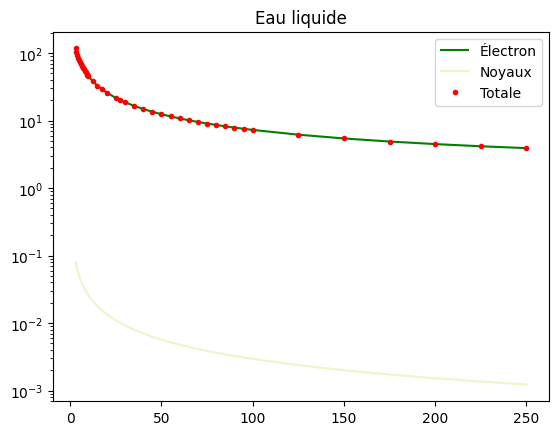

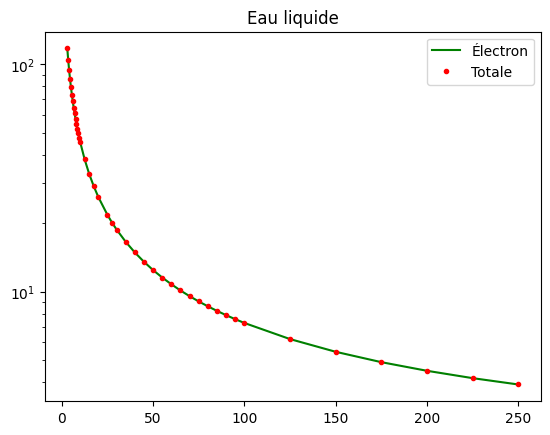

In [55]:
Ke_Mev_eau_liquide, \
Stopping_power_Electronic_eau_liquide, \
Stopping_power_Nuclear_eau_liquide, \
Stopping_power_total_eau_liquide = np.loadtxt("data_eau_liquide.txt", unpack=True)

plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide,'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Nuclear_eau_liquide, 'y', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Totale")
plt.legend()
plt.show()

plt.title("Eau liquide")

plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_Electronic_eau_liquide, 'g',label="Électron")
plt.semilogy(Ke_Mev_eau_liquide, Stopping_power_total_eau_liquide, '.r',label="Totale")
plt.legend()

plt.show()


Nous pouvons voir qu'il n'est pas nécessaire de considérer l'effet atomique. En effet, sa contribution est très minime. Le premier graph montre les contribution de toutes les parties alors que le deuxième graph montre le stopping power total et électronique.

Pour l'os compact:

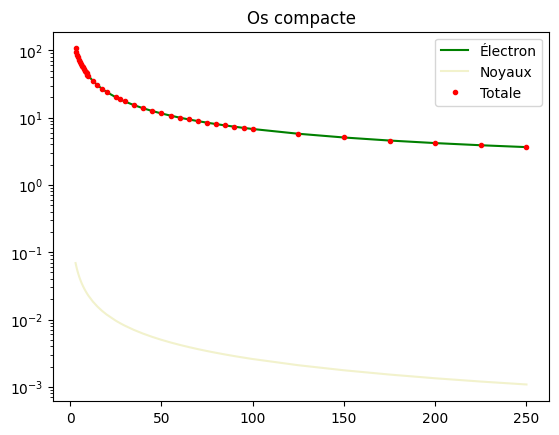

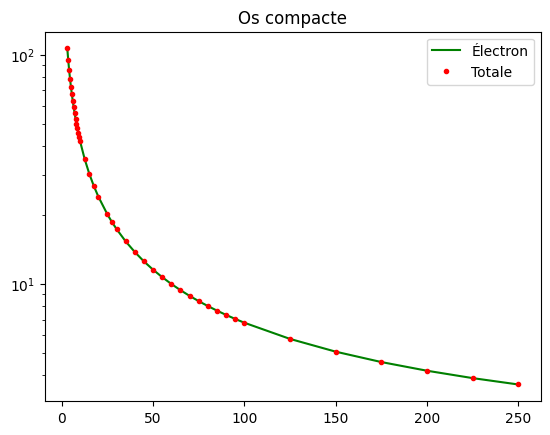

In [56]:

Ke_Mev_os_compact , \
Stopping_power_Electronic_os_compact, \
Stopping_power_Nuclear_os_compact, \
Stopping_power_total_os_compact = np.loadtxt("data_os_compact.txt", unpack=True)

plt.title("Os compacte")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact,'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_Nuclear_os_compact, 'y', alpha=0.2,label="Noyaux")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Totale")
plt.legend()
plt.show()
plt.title("Os compacte")

plt.semilogy(Ke_Mev_os_compact, Stopping_power_Electronic_os_compact, 'g',label="Électron")
plt.semilogy(Ke_Mev_os_compact, Stopping_power_total_os_compact, '.r',label="Totale")
plt.legend()

plt.show()

# Q4

À partir de l'équation suivante $ \frac{S_{col}}{\rho} = - \left( \frac{1}{\rho} \frac{dT}{dx} \right)_{col} $ on peut réexprimer dx en fonction du reste. $$ dx = -\frac{dT}{S_{col}} $$ On obtient ensuite $$ x = -\int^{T_i}_0 \frac{dT}{S_{col}}$$

En prenant l'inverse du pouvoir d'arrêt, cela nous permet d'avoir les unités de longueurs par rapport de l'énergie. On intègre ensuite sur ces unités de longueurs pour obtenir l'entièreté de la porté.


In [5]:
@np.vectorize
@lru_cache(maxsize=None)
def inverse_scol_water(T):
    return 1/SCol_water(T)

@np.vectorize
@lru_cache(maxsize=None)
def inverse_scol_bone(T):
    return 1/SCol_bone(T)

# Q5 

## À améliorer:
Équation complexe, il n’existe pas de solution analytique générale permettant de relier directement l’énergie initiale d’un proton à sa portée dans un milieu donné. $\frac{1}{\ln(x)}$ ne s'intègre pas.

# Q6

Méthode du trapèse

In [6]:
def n_valeurs():
    puissance_de_2 = [2**i for i in range(1, 26)]
    return puissance_de_2

In [7]:
def trapeze_sans_erreur_optimise(Bone_water, N, a, b):
    h = (b - a) / N
    x = np.linspace(a + h, b - h, N - 1)
    y = Bone_water(x)
    I = h * (0.5 * y[0] + 0.5 * y[-1] + np.sum(y[1:-1]))
    return I

In [8]:
def trapeze_avec_erreur_optimise(water_bone, a, b, n_valeurs, tol):
    n_liste = []
    i_liste = []
    erreurs_liste = []

    I_avant = None

    for N in n_valeurs:
        # Points équidistants pour la subdivision
        x = np.linspace(a, b, N + 1)
        h = (b - a) / N

        # Calcul vectorisé de la somme des termes
        y = water_bone(x)
        I_maintenant = h * (0.5 * y[0] + 0.5 * y[-1] + np.sum(y[1:-1]))

        # Stocker les résultats
        n_liste.append(N)
        i_liste.append(I_maintenant)

        # Calcul de l'erreur si possible
        if I_avant is not None:
            erreur = abs(I_maintenant - I_avant) / 3
            erreurs_liste.append(erreur)

            print(f"N = {N}, I = {I_maintenant}, Erreur = {erreur}")

            # Vérifier la tolérance
            if erreur < tol:
                return I_maintenant, n_liste, i_liste, erreurs_liste
        else:
            erreurs_liste.append(None)  # Pas d'erreur pour la première approximation

        # Mise à jour de I_avant
        I_avant = I_maintenant

    return I_maintenant, n_liste, i_liste, erreurs_liste


In [17]:
I_maintenant_Trapeze_eau, N_liste_trapeze_eau, I_eau_trapeze, erreur_eau_trapeze = trapeze_avec_erreur_optimise(inverse_scol_water, 3, 150, n_valeurs(), np.finfo(float).eps)

N = 4, I = 15.624824981075848, Erreur = 0.11218425416302935
N = 8, I = 15.718567811364574, Erreur = 0.031247610096241846
N = 16, I = 15.743901668289759, Erreur = 0.008444618975061621
N = 32, I = 15.750545617098046, Erreur = 0.0022146496027624827
N = 64, I = 15.752246221407278, Erreur = 0.000566868103077193
N = 128, I = 15.752675223919953, Erreur = 0.00014300083755832324
N = 256, I = 15.752782772519208, Erreur = 3.584953308492326e-05
N = 512, I = 15.752809679808557, Erreur = 8.96909644983642e-06
N = 1024, I = 15.752816407919049, Erreur = 2.2427034972830975e-06
N = 2048, I = 15.752818090027676, Erreur = 5.607028755368523e-07
N = 4096, I = 15.752818510559903, Erreur = 1.4017740923577549e-07
N = 8192, I = 15.752818615693277, Erreur = 3.5044458002175816e-08
N = 16384, I = 15.752818641976639, Erreur = 8.761120421733418e-09
N = 32768, I = 15.75281864854748, Erreur = 2.1902805495225644e-09
N = 65536, I = 15.752818650190193, Erreur = 5.475708775293242e-10
N = 131072, I = 15.752818650600869, Err

In [16]:
I_maintenant_Trapeze_bone, N_liste_trapeze_bone, I_bone_trapeze, erreur_bone_trapeze = trapeze_avec_erreur_optimise(inverse_scol_bone, 3, 150, n_valeurs(), np.finfo(float).eps)

N = 4, I = 9.08415350939609, Erreur = 0.06580303912714432
N = 8, I = 9.13924059312755, Erreur = 0.01836236124381981
N = 16, I = 9.154147595878094, Erreur = 0.004969000916847932
N = 32, I = 9.158060148104108, Erreur = 0.0013041840753379812
N = 64, I = 9.159061978729111, Erreur = 0.00033394354166797296
N = 128, I = 9.15931473599308, Erreur = 8.425242132285386e-05
N = 256, I = 9.159378102922771, Erreur = 2.1122309896999997e-05
N = 512, I = 9.159393956647996, Erreur = 5.284575075018931e-06
N = 1024, I = 9.159397920846096, Erreur = 1.3213993668159674e-06
N = 2048, I = 9.159398911943832, Erreur = 3.3036591181219893e-07
N = 4096, I = 9.159399159721284, Erreur = 8.259248396313978e-08
N = 8192, I = 9.159399221665836, Erreur = 2.0648184199482483e-08
N = 16384, I = 9.159399237151986, Erreur = 5.1620497506140355e-09
N = 32768, I = 9.159399241023523, Erreur = 1.2905125856832456e-09
N = 65536, I = 9.159399241991409, Erreur = 3.226284424802846e-10
N = 131072, I = 9.15939924223338, Erreur = 8.06572586

Méthode de Romberg

In [18]:
def romberg_sans_erreur(water_bone, a, b, N):

    # Initialisation
    R = np.zeros((2, 2))  # Matrice de Romberg (seulement 2 x 2 nécessaire ici)

    # Calcul de R[0, 0] (première approximation avec trapèzes)
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    R[0, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))

    # Calcul de R[1, 0] (prochaine approximation avec un pas plus fin)
    N_fine = 2 * N  # Augmenter la subdivision
    h_fine = (b - a) / N_fine
    x_fine = np.linspace(a, b, N_fine + 1)
    R[1, 0] = h_fine * (water_bone(x_fine[0]) + water_bone(x_fine[-1])) / 2 + h_fine * np.sum(water_bone(x_fine[1:-1]))

    # Extrapolation de Richardson
    R[1, 1] = R[1, 0] + (R[1, 0] - R[0, 0]) / (4 - 1)

    # Calcul de l'erreur
    erreur = abs(R[1, 1] - R[0, 0])

    # Résultats finaux
    return R[1, 1]


In [19]:
def romberg_avec_erreur(water_bone, a, b, n_values=None, err_toléré=None):

    if n_values is None:
        n_values = [2 ** i for i in range(2, 27)]  # Par défaut, puissances de 2 de 4 à 2^26

    # Initialisation
    max_iter = len(n_values)  # Taille de la liste n_values
    R = np.zeros((max_iter, max_iter))  # Matrice de Romberg
    I = []  # Liste des valeurs d'intégrale (diagonale de R)
    erreurs = []  # Liste des erreurs
    N_liste = []  # Liste des subdivisions \( N \)

    # Calcul de R[0, 0] (première approximation)
    N = n_values[0]
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    R[0, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))
    I.append(R[0, 0])  # Ajouter la première estimation intégrale
    N_liste.append(N)

    # Remplissage de la matrice de Romberg
    for k in range(1, max_iter):
        N = n_values[k]
        h = (b - a) / N  # Calcul du pas
        x = np.linspace(a, b, N + 1)  # Points intermédiaires

        # Calcul des points intermédiaires pour la nouvelle subdivision
        R[k, 0] = h * (water_bone(x[0]) + water_bone(x[-1])) / 2 + h * np.sum(water_bone(x[1:-1]))

        # Extrapolation de Richardson
        for j in range(1, k + 1):
            R[k, j] = R[k, j - 1] + (R[k, j - 1] - R[k - 1, j - 1]) / (4 ** j - 1)

        # Ajout à la liste des estimations intégrales et des subdivisions
        I.append(R[k, k])  # Ajouter la valeur diagonale comme estimation intégrale
        N_liste.append(N)

        # Évaluation de l'erreur
        erreur = abs(R[k, k] - R[k - 1, k - 1])
        erreurs.append(erreur)

        # Arrêt si la précision souhaitée est atteinte
        if erreur < err_toléré:
            return N_liste, I, erreurs

    # Retourne les résultats si aucune tolérance n'est respectée avant la fin
    return N_liste, I, erreurs


In [20]:
N_liste_romberg_eau, I_eau_romberg, erreurs_eau_romberg = romberg_avec_erreur(inverse_scol_water, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

In [21]:
N_liste_romberg_bone, I_bone_romberg, erreurs_bone_romberg = romberg_avec_erreur(inverse_scol_bone, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

# Q7
Tracez un graphique de la portée calculée par chaque méthode en fonction du nombre d’échantillons (de tranches) considéré. Le même graphique rapportera l’estimation pratique de l’erreur d’approximation pour les deux méthodes (avec une échelle différente en ordonnée). Votre graphique comprendra des points choisis de façon à bien représenter le comportement de vos algorithmes (des échelles logarithmiques pourraient être nécessaires). Doubler le nombre de tranches entre chaque évaluation pourrait s’avérer judicieux.

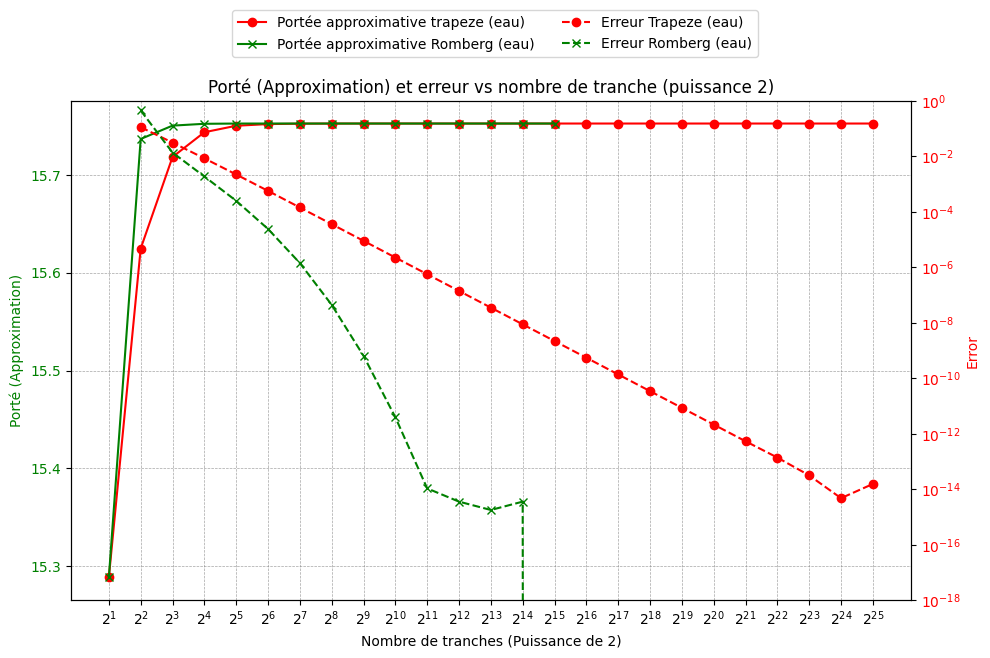

In [22]:
N = N_liste_trapeze_eau

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Nombre de tranches (Puissance de 2)")
ax1.set_ylabel("Porté (Approximation)", color="green")  # y-axis de gauche

ax1.plot(N, I_eau_trapeze, label="Portée approximative trapeze (eau)", marker="o", color="red")
ax1.plot(N_liste_romberg_eau, I_eau_romberg, label="Portée approximative Romberg (eau)", marker="x", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="red")  # y-axis de droite
ax2.plot(N, erreur_eau_trapeze, label="Erreur Trapeze (eau)", marker="o", linestyle="--", color="red")
ax2.plot(N_liste_romberg_eau[1:], erreurs_eau_romberg, label="Erreur Romberg (eau)", marker="x", linestyle="--", color="green")
ax2.set_yscale('log')
ax2.set_ylim(1e-18, 1)
ax2.tick_params(axis="y", labelcolor="red")

plt.title("Porté (Approximation) et erreur vs nombre de tranche (puissance 2)")
ax1.set_xscale('log', base=2)  # Logarithmique
ax1.set_xticks(N)

fig.tight_layout()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()


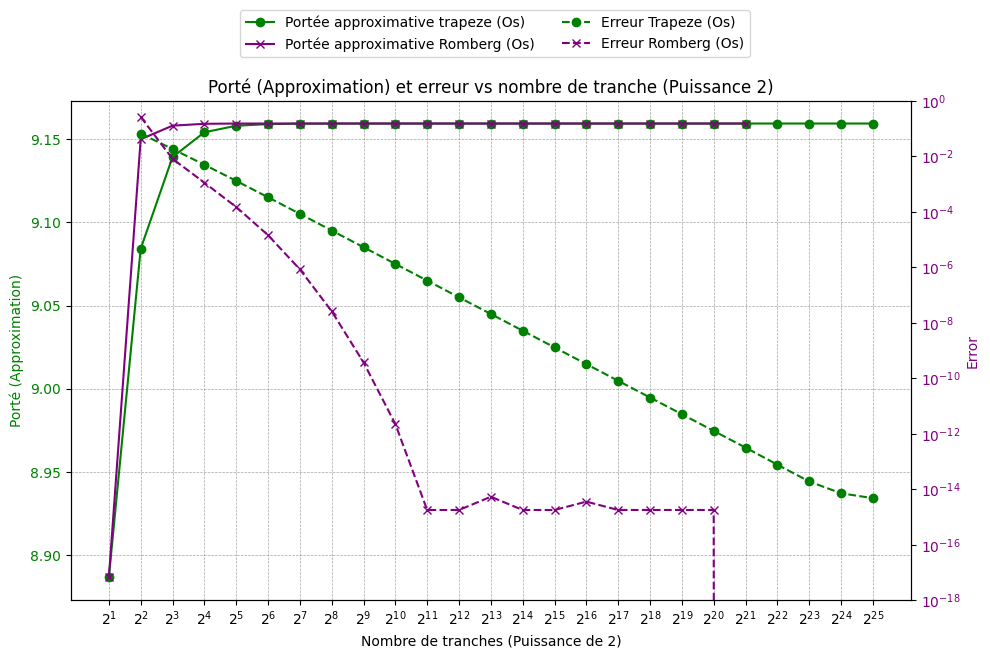

In [23]:
N_liste, I, erreurs = romberg_avec_erreur(inverse_scol_bone, 3, 150, n_values=n_valeurs(), err_toléré=np.finfo(float).eps)

N = N_liste_trapeze_bone

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Nombre de tranches (Puissance de 2)")
ax1.set_ylabel("Porté (Approximation)", color="green")  # y-axis de gauche

ax1.plot(N, I_bone_trapeze, label="Portée approximative trapeze (Os)", marker="o", color="green")
ax1.plot(N_liste_romberg_bone, I, label="Portée approximative Romberg (Os)", marker="x", color="purple")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel("Error", color="purple")  # y-axis de droite
ax2.plot(N, erreur_bone_trapeze, label="Erreur Trapeze (Os)", marker="o", linestyle="--", color="green")
ax2.plot(N_liste_romberg_bone[1:], erreurs, label="Erreur Romberg (Os)", marker="x", linestyle="--", color="purple")
ax2.set_yscale('log')
ax2.set_ylim(1e-18, 1)
ax2.tick_params(axis="y", labelcolor="purple")

plt.title("Porté (Approximation) et erreur vs nombre de tranche (Puissance 2)")
ax1.set_xscale('log', base=2)  # Logarithmique
ax1.set_xticks(N)

fig.tight_layout()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=2)

plt.show()

## Q8
la dérivé de $ S^{-1}_{col}$, selon mon calcul à la main est : $$  \frac{d S^{-1}_{col}}{dT} = \frac{-1}{2\pi r_e^2 m_e c^4 n_e m_p } 
\left( \frac{\left(\frac{-2\gamma^3}{(\gamma^2 - 1)^2} + \frac{2\gamma}{\gamma^2 -1}\right) 
\ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) + \frac{1}{\gamma^2 -1} \left( 4\gamma -\frac{\delta}{b+\delta \gamma}\right) }{\left[ \ln \left(\frac{a^2(\gamma^2 -1)^2}{I^2 (b+\delta \gamma)}\right) \frac{\gamma^2}{\gamma^2 -1} -2\right]^2}\right)$$

In [69]:
T = sp.Symbol('T', real=True, positive=True)  # Temperature
ne = sp.Symbol('n_e', real=True, positive=True)  # Electron number density
IMeV = sp.Symbol('I_{MeV}', real=True, positive=True)  # Ionization energy in MeV
re = sp.Symbol('r_e', real=True, positive=True)  # Classical electron radius
me = sp.Symbol('m_e', real=True, positive=True)  # Electron mass
mp = sp.Symbol('m_p', real=True, positive=True)  # Proton mass
c = sp.Symbol('c', real=True, positive=True)  # Speed of light

# Define gamma factor
gamma = T / (mp * c**2) + 1

# Define T_max
T_max = (2 * me * c**2 * (gamma**2 - 1)) / (1 + 2 * (me / mp) * gamma + (me / mp)**2)

# Define beta
beta = 1 / (gamma**2 / (gamma**2 - 1))

# Define U
U = 2 * sp.pi * re**2 * me * c**2 * ne

# Define S_col expression
S_col = U / (beta**2) * (sp.log((2 * me * c**2 * beta**2 * gamma**2 * T_max) / IMeV**2) - 2 * beta**2)

# Display the expression


In [70]:
f = S_col**-1

In [71]:
f = sp.simplify(f)

In [72]:
dfdT = sp.diff(f,T)

In [73]:
dfdT = sp.together(dfdT)

## Question 9

Rapportez vos portées calulées dans un tableau, qui comprendra aussi les erreurs d’approximation calculées (pour la méthode des trapezes) et évalué de façon pratique (pour la méthode des trapèzes et de Romberg). Il s’agit essentiellement des résultats d́eja obtenus (auxquels on ajoute les erreurs calculées pour la methode des trapèzes). Commentéz vos résultats.


C:\Users\micha\AppData\Local\Temp\ipykernel_3512\2949896723.py:1: UserWarning: legacy printing option can currently only be '1.13', '1.21', or `False`
  np.set_printoptions(legacy='1.25')


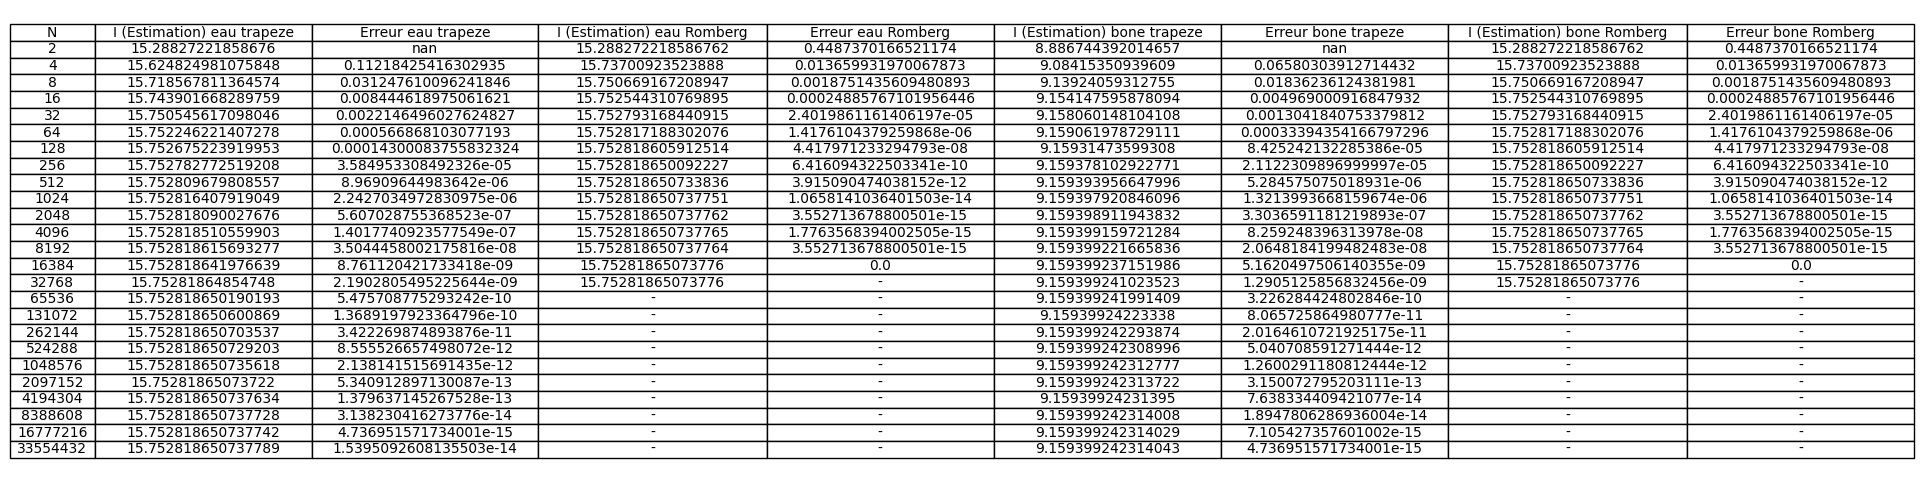

In [74]:
np.set_printoptions(legacy='1.25')

eau_trapeze = {
    "N": N_liste_trapeze_eau,
    "I (Estimation)": I_eau_trapeze,
    "Erreur": erreur_eau_trapeze
}

eau_romberg = {
    "N": N_liste_romberg_eau,
    "I (Estimation)": I_eau_romberg,
    "Erreur": erreurs_eau_romberg
}

bone_trapeze = {
    "N": N_liste_trapeze_bone,
    "I (Estimation)": I_bone_trapeze,
    "Erreur": erreur_bone_trapeze
}

bone_romberg = {
    "N": N_liste_romberg_bone,
    "I (Estimation)": I_bone_romberg,
    "Erreur": erreurs_bone_romberg
}

# Trouver la longueur maximale parmi les listes de tous les dictionnaires
longueur_max = max(
    len(eau_trapeze["N"]),
    len(eau_romberg["N"]),
    len(bone_trapeze["N"]),
    len(bone_romberg["N"])
)

# Fonction pour compléter les listes courtes avec des valeurs "-"
def completer_liste(liste, longueur_cible):
    return liste + ["-"] * (longueur_cible - len(liste))

# Liste unique pour les valeurs de N
N_values = completer_liste(list(eau_trapeze["N"]), longueur_max)

# Simplification en utilisant la liste partagée pour les valeurs de 'N'
Dictionnaire = {
    "N": N_values,
    "I (Estimation) eau trapeze": completer_liste(list(eau_trapeze["I (Estimation)"]), longueur_max),
    "Erreur eau trapeze": completer_liste(list(eau_trapeze["Erreur"]), longueur_max),
    "I (Estimation) eau Romberg": completer_liste(list(eau_romberg["I (Estimation)"]), longueur_max),
    "Erreur eau Romberg": completer_liste(list(eau_romberg["Erreur"]), longueur_max),
    "I (Estimation) bone trapeze": completer_liste(list(bone_trapeze["I (Estimation)"]), longueur_max),
    "Erreur bone trapeze": completer_liste(list(bone_trapeze["Erreur"]), longueur_max),
    "I (Estimation) bone Romberg": completer_liste(list(bone_romberg["I (Estimation)"]), longueur_max),
    "Erreur bone Romberg": completer_liste(list(bone_romberg["Erreur"]), longueur_max)
}

# Création du DataFrame à partir du dictionnaire
table_combine = pd.DataFrame(Dictionnaire)

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(12, 6))  # Taille de la figure

# Masquer les axes
ax.axis("off")  # Supprime les bordures et numéros

# Affichage du tableau (ax.table pour matplotlib)
mpl_table = ax.table(
    cellText=table_combine.values,  # Valeurs du DataFrame
    colLabels=table_combine.columns,  # Noms des colonnes
    loc="center",  # Centrer le tableau sur la figure
    cellLoc="center"  # Centrer le contenu des cellules
)

# Ajustement de la figure et du tableau
mpl_table.auto_set_font_size(False)  # Autorise le contrôle de la taille des polices
mpl_table.set_fontsize(10)  # Définir une taille de police
mpl_table.auto_set_column_width(col=list(range(len(table_combine.columns))))  # Ajustement automatique des colonnes

# Afficher la figure
plt.show()


# **Optimisation**
## Question 10

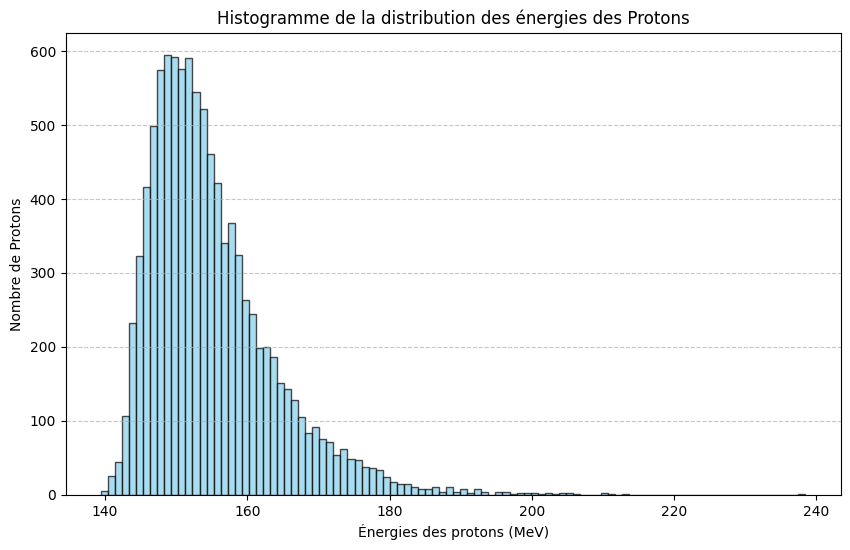

In [14]:
energy_proton = scipy.stats.moyal.rvs(loc = 150, scale = 4, size = 10000)

# Trouver les bornes de la distribution
plt.figure(figsize=(10, 6))
plt.hist(energy_proton, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramme de la distribution des énergies des Protons")
plt.xlabel("Énergies des protons (MeV)")
plt.ylabel("Nombre de Protons")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Question 11

In [ ]:
I_final_trapeze_water_11, N_trapeze_water_11, I_trapeze_water_11, erreur_trapeze_water_11 = trapeze_avec_erreur_optimise(inverse_scol_water, 3, 150, n_valeurs(), 1.49e-8)

I_final_trapeze_bone_11, N_trapeze_bone_11, I_trapeze_bone_11, erreur_trapreze_bone_11 = trapeze_avec_erreur_optimise(inverse_scol_bone, 3, 150, n_valeurs(), 1.49e-8)

N_romberg_water_11, I_romberg_water_11, erreurs_romberg_water_11 = romberg_avec_erreur(inverse_scol_water, 3, 150, n_values=n_valeurs(), err_toléré=1.49e-8)

N_romberg_bone_11, I_romberg_bone_11, erreurs_romberg_bone_11 = romberg_avec_erreur(inverse_scol_bone, 3, 150, n_values=n_valeurs(), err_toléré=1.49e-8)

def interpolation_lineaire(N1, E1, N2, E2, erreur_cible):
   # Relation de la droite entre (log(N), log(erreur)) pour estimer N
   logN1, logN2 = np.log(N1), np.log(N2)
   logE1, logE2 = np.log(E1), np.log(E2)
   pente = (logE2 - logE1) / (logN2 - logN1)  # Pente (variation logarithmique)
   logNcible = logN1 + (np.log(erreur_cible) - logE1) / pente  # Point cible
   return np.exp(logNcible)  # Retourner N estimée

N_exact = interpolation_lineaire(8192, 2.014915760166029e-08, 16384, 5.037293249188224e-09, 1.48e-8)
print(f"N interpolé pour Os Compact et Eau liquide pour trapeze: {N_exact}")

print(f"La valeurs de N pour romberg eau liquide pour atteindre la tolérance de Quad est {N_romberg_water_11[-2]}")

print(f"La valeurs de N pour romberg Os compact pour atteindre la tolérance de Quad est {N_romberg_bone_11[-2]}")

N = 4, I = 15.624824981075848, Erreur = 0.11218425416302935
N = 8, I = 15.718567811364574, Erreur = 0.031247610096241846
N = 16, I = 15.743901668289759, Erreur = 0.008444618975061621
N = 32, I = 15.750545617098046, Erreur = 0.0022146496027624827
N = 64, I = 15.752246221407278, Erreur = 0.000566868103077193
N = 128, I = 15.752675223919953, Erreur = 0.00014300083755832324
N = 256, I = 15.752782772519208, Erreur = 3.584953308492326e-05
N = 512, I = 15.752809679808557, Erreur = 8.96909644983642e-06
N = 1024, I = 15.752816407919049, Erreur = 2.2427034972830975e-06
N = 2048, I = 15.752818090027676, Erreur = 5.607028755368523e-07
N = 4096, I = 15.752818510559903, Erreur = 1.4017740923577549e-07
N = 8192, I = 15.752818615693277, Erreur = 3.5044458002175816e-08
N = 16384, I = 15.752818641976639, Erreur = 8.761120421733418e-09
N = 4, I = 9.08415350939609, Erreur = 0.06580303912714432
N = 8, I = 9.13924059312755, Erreur = 0.01836236124381981
N = 16, I = 9.154147595878094, Erreur = 0.0049690009168

In [ ]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

min_value = 3

# Configurer le niveau de journalisation
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

result_trapeze = np.zeros_like(energy_proton, dtype=np.float32)
result_romberg = np.zeros_like(energy_proton, dtype=np.float32)
result_quad = np.zeros_like(energy_proton, dtype=np.float32)

def quad_method(fc ,energy):
    return integrate.quad(fc, min_value, energy)[0]

# Calcul avec la méthode des trapèzes
def trapeze_method(fc):
    for i, energy in enumerate(energy_proton):
        if i % 100 == 0:
            logging.info(f"[Trapèze] Calcul photon {i + 1}/{len(energy_proton)} : énergie = {energy}")
        result_trapeze[i] = trapeze_sans_erreur_optimise(fc, 9559, min_value, energy)


# Calcul avec la méthode de Romberg
def romberg_method(fc):
    for i, energy in enumerate(energy_proton):
        if i % 100 == 0:
            logging.info(f"[Romberg] Calcul photon {i + 1}/{len(energy_proton)} : énergie = {energy}")
        result_romberg[i] = romberg_sans_erreur(fc, min_value, energy, N_romberg_bone_11[-2])


# Calcul avec scipy.integrate.quad
def quad_comp(fc):
    for i, energy in enumerate(energy_proton):
        if i % 100 == 0:
            logging.info(f"[Quad] Calcul photon {i + 1}/{len(energy_proton)} : énergie = {energy}")
        result_quad[i] = quad_method(fc, energy)



In [84]:
## Nombre total de protons (énergies)
n_protons = len(energy_proton)

time_trapeze = timeit(lambda: trapeze_method(inverse_scol_water), number=1)
time_romberg = timeit(lambda: romberg_method(inverse_scol_water), number=1)
time_quad = timeit(lambda: quad_comp(inverse_scol_water), number=1)

# Calcul des protons par seconde
protons_per_second_trapeze = n_protons / time_trapeze
protons_per_second_romberg = n_protons / time_romberg
protons_per_second_quad = n_protons / time_quad

# Résultats affichés
print("Temps de calcul et protons par seconde pour eau liquide:")
print(f"Méthode Trapèze : {time_trapeze:.2f} secondes, {protons_per_second_trapeze:.2f} protons/sec")
print(f"Méthode Romberg : {time_romberg:.2f} secondes, {protons_per_second_romberg:.2f} protons/sec")
print(f"SciPy Quad : {time_quad:.2f} secondes, {protons_per_second_quad:.2f} protons/sec")


2025-02-21 11:57:54,815 - [Trapèze] Calcul photon 1/10000 : énergie = 154.79492182834593
2025-02-21 11:58:00,162 - [Trapèze] Calcul photon 101/10000 : énergie = 150.70150627894265
2025-02-21 11:58:05,436 - [Trapèze] Calcul photon 201/10000 : énergie = 145.65770297911945
2025-02-21 11:58:10,712 - [Trapèze] Calcul photon 301/10000 : énergie = 152.29412570073885
2025-02-21 11:58:16,022 - [Trapèze] Calcul photon 401/10000 : énergie = 160.659272880759
2025-02-21 11:58:21,152 - [Trapèze] Calcul photon 501/10000 : énergie = 153.52526499277533
2025-02-21 11:58:26,539 - [Trapèze] Calcul photon 601/10000 : énergie = 163.43584895678538
2025-02-21 11:58:31,742 - [Trapèze] Calcul photon 701/10000 : énergie = 160.2502292234658
2025-02-21 11:58:36,825 - [Trapèze] Calcul photon 801/10000 : énergie = 155.4300925239333
2025-02-21 11:58:41,967 - [Trapèze] Calcul photon 901/10000 : énergie = 179.30708952093772
2025-02-21 11:58:47,265 - [Trapèze] Calcul photon 1001/10000 : énergie = 156.74302756718495
2025

Temps de calcul et protons par seconde pour eau liquide:
Méthode Trapèze : 535.76 secondes, 18.67 protons/sec
Méthode Romberg : 61.05 secondes, 163.81 protons/sec
SciPy Quad : 10.55 secondes, 947.69 protons/sec


In [ ]:
# Nombre total de protons (énergies)
n_protons = len(energy_proton)

time_trapeze = timeit(lambda: trapeze_method(inverse_scol_bone), number=1)
time_romberg = timeit(lambda: romberg_method(inverse_scol_bone), number=1)
time_quad = timeit(lambda: quad_comp(inverse_scol_bone), number=1)

# Calcul des protons par seconde
protons_per_second_trapeze = n_protons / time_trapeze
protons_per_second_romberg = n_protons / time_romberg
protons_per_second_quad = n_protons / time_quad

# Résultats affichés
print("Temps de calcul et protons par seconde pour Os Compact:")
print(f"Méthode Trapèze : {time_trapeze:.2f} secondes, {protons_per_second_trapeze:.2f} protons/sec")
print(f"Méthode Romberg : {time_romberg:.2f} secondes, {protons_per_second_romberg:.2f} protons/sec")
print(f"SciPy Quad : {time_quad:.2f} secondes, {protons_per_second_quad:.2f} protons/sec")

2025-02-21 00:53:34,190 - [Trapèze] Calcul photon 1/10000 : énergie = 162.30735051014054
2025-02-21 00:53:55,496 - [Trapèze] Calcul photon 101/10000 : énergie = 164.0493489122769
2025-02-21 00:54:00,901 - [Trapèze] Calcul photon 201/10000 : énergie = 152.550897140743
2025-02-21 00:54:06,228 - [Trapèze] Calcul photon 301/10000 : énergie = 163.88320810542024
2025-02-21 00:54:11,665 - [Trapèze] Calcul photon 401/10000 : énergie = 145.71371252232223
2025-02-21 00:54:17,250 - [Trapèze] Calcul photon 501/10000 : énergie = 145.4203872502163
2025-02-21 00:54:22,619 - [Trapèze] Calcul photon 601/10000 : énergie = 146.77373042337126
2025-02-21 00:54:28,071 - [Trapèze] Calcul photon 701/10000 : énergie = 146.88323662700435
2025-02-21 00:54:33,487 - [Trapèze] Calcul photon 801/10000 : énergie = 160.22564440407479
2025-02-21 00:54:38,849 - [Trapèze] Calcul photon 901/10000 : énergie = 152.29709503725286
2025-02-21 00:54:44,187 - [Trapèze] Calcul photon 1001/10000 : énergie = 151.0064671874703
2025-

Temps de calcul et protons par seconde pour Os Compact:
Méthode Trapèze : 560.99 secondes, 17.83 protons/sec
Méthode Romberg : 59.86 secondes, 167.07 protons/sec
SciPy Quad : 10.56 secondes, 947.06 protons/sec


## Q12

2025-02-21 12:09:59,022 - [Quad] Calcul photon 1/10000 : énergie = 154.79492182834593
2025-02-21 12:09:59,078 - [Quad] Calcul photon 101/10000 : énergie = 150.70150627894265
2025-02-21 12:09:59,130 - [Quad] Calcul photon 201/10000 : énergie = 145.65770297911945
2025-02-21 12:09:59,188 - [Quad] Calcul photon 301/10000 : énergie = 152.29412570073885
2025-02-21 12:09:59,239 - [Quad] Calcul photon 401/10000 : énergie = 160.659272880759
2025-02-21 12:09:59,288 - [Quad] Calcul photon 501/10000 : énergie = 153.52526499277533
2025-02-21 12:09:59,340 - [Quad] Calcul photon 601/10000 : énergie = 163.43584895678538
2025-02-21 12:09:59,392 - [Quad] Calcul photon 701/10000 : énergie = 160.2502292234658
2025-02-21 12:09:59,443 - [Quad] Calcul photon 801/10000 : énergie = 155.4300925239333
2025-02-21 12:09:59,494 - [Quad] Calcul photon 901/10000 : énergie = 179.30708952093772
2025-02-21 12:09:59,547 - [Quad] Calcul photon 1001/10000 : énergie = 156.74302756718495
2025-02-21 12:09:59,596 - [Quad] Calc

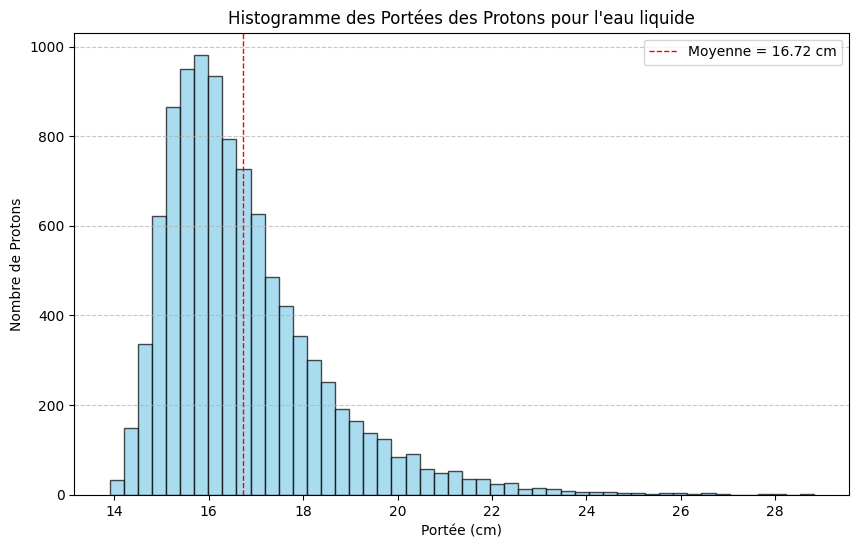

Moyenne: 16.72
Écart-type: 8.77


In [87]:
quad_comp(inverse_scol_water)

# Tracé de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(result_quad, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramme des Portées des Protons pour l'eau liquide")
plt.xlabel("Portée (cm)")
plt.ylabel("Nombre de Protons")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calcul des statistiques descriptives
mean = np.mean(result_quad)
std_dev = np.std(energy_proton)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f"Moyenne = {mean:.2f} cm")
plt.legend()
plt.show()

# Anecdote : Affichage des statistiques pour commentaire
print(f"Moyenne: {mean:.2f}")
print(f"Écart-type: {std_dev:.2f}")


2025-02-21 12:10:05,585 - [Quad] Calcul photon 1/10000 : énergie = 154.79492182834593
2025-02-21 12:10:05,637 - [Quad] Calcul photon 101/10000 : énergie = 150.70150627894265
2025-02-21 12:10:05,685 - [Quad] Calcul photon 201/10000 : énergie = 145.65770297911945
2025-02-21 12:10:05,735 - [Quad] Calcul photon 301/10000 : énergie = 152.29412570073885
2025-02-21 12:10:05,787 - [Quad] Calcul photon 401/10000 : énergie = 160.659272880759
2025-02-21 12:10:05,834 - [Quad] Calcul photon 501/10000 : énergie = 153.52526499277533
2025-02-21 12:10:05,882 - [Quad] Calcul photon 601/10000 : énergie = 163.43584895678538
2025-02-21 12:10:05,929 - [Quad] Calcul photon 701/10000 : énergie = 160.2502292234658
2025-02-21 12:10:05,977 - [Quad] Calcul photon 801/10000 : énergie = 155.4300925239333
2025-02-21 12:10:06,024 - [Quad] Calcul photon 901/10000 : énergie = 179.30708952093772
2025-02-21 12:10:06,072 - [Quad] Calcul photon 1001/10000 : énergie = 156.74302756718495
2025-02-21 12:10:06,118 - [Quad] Calc

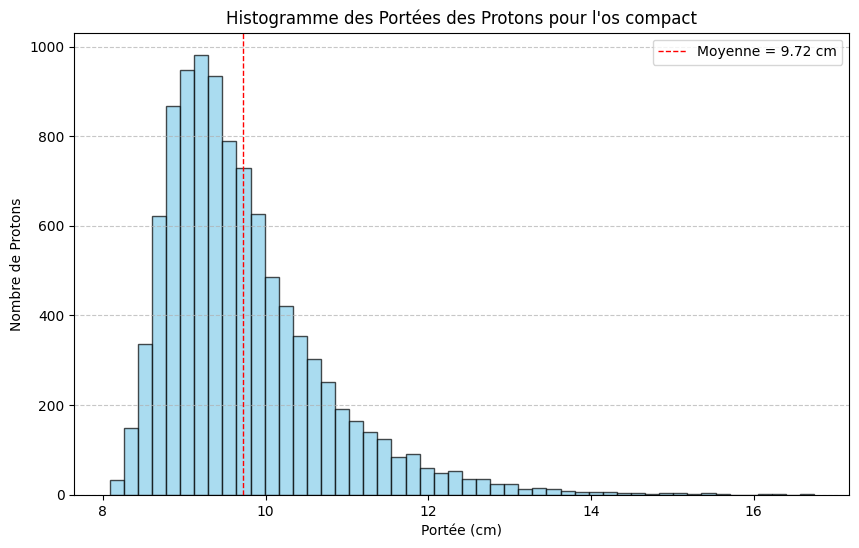

Moyenne: 9.72
Écart-type: 8.77


In [88]:
# Q.12
quad_comp(inverse_scol_bone)

# Tracé de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(result_quad, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramme des Portées des Protons pour l'os compact")
plt.xlabel("Portée (cm)")
plt.ylabel("Nombre de Protons")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calcul des statistiques descriptives
mean = np.mean(result_quad)
std_dev = np.std(energy_proton)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f"Moyenne = {mean:.2f} cm")

plt.legend()
plt.show()

# Anecdote : Affichage des statistiques pour commentaire
print(f"Moyenne: {mean:.2f}")
print(f"Écart-type: {std_dev:.2f}")


## Q13

**Équation 11**
$$
s = \int^{T_i}_{T_f}\frac{dT'}{S_{col}'}

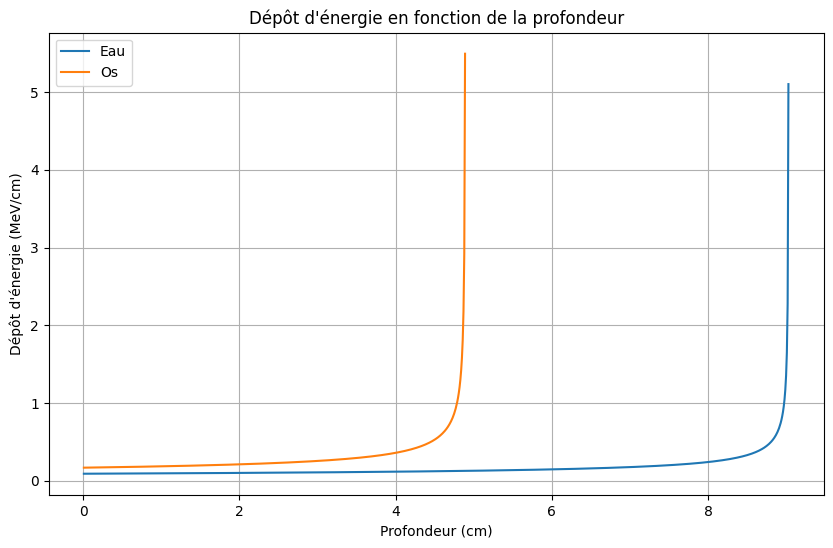

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constantes
E_initial = 150  # Energie cinétique initiale en MeV
rho_eau = 1.0  # Densité de l'eau en g/cm^3
rho_os = 1.85  # Densité de l'os en g/cm^3
dx = 0.01  # Pas de profondeur en cm

# Fonction de perte d'énergie (Bethe-Bloch simplifiée)
def dE_dx(E, rho):
    K = 0.307075  # MeV cm^2/g
    Z = 1  # Charge du proton
    A = 1  # Nombre de masse du proton
    I = 75e-6  # Potentiel moyen d'ionisation en MeV
    beta = np.sqrt(1 - (1 / (1 + E / 938.272))**2)
    return K * Z**2 * rho / (A * beta**2) * (0.5 * np.log(2 * 938.272 * beta**2 * (1 + E / 938.272) / I) - beta**2)

# Simulation du transport des protons
def simulate_transport(E_initial, rho):
    E = E_initial
    depth = 0
    depths = []
    energies = []
    while E > 0:
        dE = dE_dx(E, rho) * dx
        E -= dE
        depth += dx
        depths.append(depth)
        energies.append(dE)
    return depths, energies

# Simulation pour l'eau
depths_eau, energies_eau = simulate_transport(E_initial, rho_eau)

# Simulation pour l'os
depths_os, energies_os = simulate_transport(E_initial, rho_os)

# Tracé des résultats
plt.figure(figsize=(10, 6))
plt.plot(depths_eau, energies_eau, label='Eau')
plt.plot(depths_os, energies_os, label='Os')
plt.xlabel('Profondeur (cm)')
plt.ylabel('Dépôt d\'énergie (MeV/cm)')
plt.title('Dépôt d\'énergie en fonction de la profondeur')
plt.legend()
plt.grid(True)
plt.show()